## AR climatology and HALO-(AC)³ ARs

This notebook creates the climatological framing of HALO-(AC)3 atmospheric rivers referring to the long-term mean (1979-2019).
AR climatology relies on AR catalogue by M. Lauer (IGMK, Cologne) that adapted the AR detection by Guan & Waliser (2015) for ERA5 input.

code by Henning Dorff:
last update 2023-05-15

In [1]:
import glob

import numpy as np
import os
import pandas as pd
import xarray as xr

import sys

In [2]:
# Navigate to AR catalogue path, needs to be configurated individually by user
current_path=os.getcwd()
major_working_path=current_path+"/../../../"
print(major_working_path)
AR_catalog_path=major_working_path+"Overall_Data\\AR_Catalogues\\ARcatalog_ERA5_march_1979-2022\\"

C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\Work\Synoptic_HALO_AC3_Paper\scripts/../../../


In [3]:
exemplaric_file_month="197903"
test_file=[]
do_testing=False

#major_path = os.path.abspath("..")
#print(major_path)
#major_path = major_path+"/../"

# Additional git repositories needed that serve for different purposes 
# regarding HALO Aircraft microwave package processing
# contact henning.dorff@uni-hamburg.de for later usage
halo_ac3_processing_path=major_working_path+'my_GIT/hamp_processing_python/'#os.path.join(major_working_path, '/PhD_UHH_WIMI/my_GIT/hamp_processing_python/')
print(halo_ac3_processing_path)

halo_ac3_processing_src_path=halo_ac3_processing_path+"src/"
halo_ac3_data_path=major_working_path+"/Work/GIT_Repository/hamp_processing_py/hamp_processing_python/"
print(halo_ac3_data_path)

sys.path.insert(1,halo_ac3_processing_path)
sys.path.insert(2,halo_ac3_processing_src_path)

C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\Work\Synoptic_HALO_AC3_Paper\scripts/../../../my_GIT/hamp_processing_python/
C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\Work\Synoptic_HALO_AC3_Paper\scripts/../../..//Work/GIT_Repository/hamp_processing_py/hamp_processing_python/


In [4]:
# Get all AR catalogue files on monthly base
do_march=True
do_april=True
# Get file list
march_list=glob.glob(AR_catalog_path+"*03.nc")

march_list=sorted(march_list)
real_march_list=march_list.copy()
april_list=glob.glob(AR_catalog_path+"*04.nc")
april_list=sorted(april_list)

if do_march and do_april:
    march_list.extend(april_list)
    file_list=march_list
elif do_march:
    file_list=march_list
elif do_april:
    file_list=april_list
file_list=sorted(file_list)

In [5]:
if do_testing:
    march_1979=xr.open_dataset(file_list[0])
    march_1979["IVT"]=np.sqrt(march_1979["ivtx"]**2+march_1979["ivty"]**2)
    test_file=march_1979
    
    pd.to_datetime(test_file.time.values[0]).month
    first_date=pd.to_datetime(test_file.time.values[0])
    year_str=str(first_date.year)
    if first_date.month==3:
        print("it is march of ", year_str)
        cutted_test=test_file.sel(time=slice(year_str+"-03-07",year_str+"-03-31"))
        print(cutted_test)

In [6]:
lower_lat=50
upper_lat=90

do_testing=True
if do_testing:
    # read exemplaric file
    center_lat=pd.Series(xr.open_dataset(march_list[0])["clat"][0,::6,0,:][0,:].values) # march_1979
    center_lon=pd.Series(xr.open_dataset(march_list[0])["clon"][0,::6,0,:][0,:].values)
    center_lon[center_lon>180]=center_lon[center_lon>180]-360
    relevant_center_lons=center_lon[center_lon>-60]
    relevant_center_lons=relevant_center_lons[relevant_center_lons<40]
    relevant_center_lats=center_lat[center_lat>lower_lat]
    
    relevant_ars=relevant_center_lons.index.intersection(relevant_center_lats.index)

C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [7]:
regional_ARs=pd.DataFrame()
f=0
for ar_file in file_list:
    #print(ar_file)
    AR_ds=xr.open_dataset(ar_file)
    
    # Cut the data for the reference period from year-03-07 to year-04-12
    #2022-03-07 to 2022-04-12 
    first_date=pd.to_datetime(AR_ds.time.values[0])
    year_str=str(first_date.year)
    if first_date.month==3:
        #print("it is march of ", year_str)
        AR_ds=AR_ds.sel(time=slice(year_str+"-03-06",year_str+"-03-31"))
    elif first_date.month==4:
        #print("it is april of", year_str)
        AR_ds=AR_ds.sel(time=slice(year_str+"-04-01",year_str+"-04-12"))
    AR_ds["ivt"]=np.sqrt(AR_ds["ivtx"]**2+AR_ds["ivty"]**2)
    
    # Allocation for loop
    values_list=[]
    # Loop over ERA timesteps
    time_array=pd.Series(AR_ds.time[:].values)
    relevant_times=AR_ds.time[::6]
    for t in range(relevant_times.shape[0]):
        # cut AR to relevant lat and lons
        center_lat=pd.Series(AR_ds["clat"][0,6*t,0,:].values)
        center_lon=pd.Series(AR_ds["clon"][0,6*t,0,:].values)
        center_lon[center_lon>180]=center_lon[center_lon>180]-360
        relevant_center_lons=center_lon[center_lon>-60]
        relevant_center_lons=relevant_center_lons[relevant_center_lons<40]
        relevant_center_lats=center_lat[center_lat>lower_lat]
        
        # the important index locator
        relevant_ars=relevant_center_lons.index.intersection(relevant_center_lats.index)
        
        time=pd.to_datetime(np.array(AR_ds.time[6*t]))
        AR_ivtx=pd.Series(np.array(AR_ds["ivtx"][0,6*t,0,:]))
        AR_ivty=pd.Series(np.array(AR_ds["ivty"][0,6*t,0,:]))
        AR_ivt=pd.Series(np.array(AR_ds["ivt"][0,6*t,0,:]))
        AR_clon=pd.Series(np.array(AR_ds["clon"][0,6*t,0,:]))
        AR_clat=pd.Series(np.array(AR_ds["clat"][0,6*t,0,:]))
        # Get index    
        for kid in relevant_ars:
            values_dict={}
            values_dict["time"]=time
            values_dict["ivt_x"] = AR_ivtx.loc[kid].astype(float)
            values_dict["ivt_y"] = AR_ivty.loc[kid].astype(float)
            values_dict["ivt"]   = AR_ivt.loc[kid].astype(float)
            values_dict["clon"]  = AR_clon.loc[kid].astype(float)
            values_dict["clat"]  = AR_clat.loc[kid].astype(float)
            values_list.append(values_dict)
        t+=1
    
    if (f==0):    
        # Assign all quantities of listed regional ARs to dataframe
        regional_ARs=pd.DataFrame(data=values_list,columns=["time","ivt_x","ivt_y",
                                                          "ivt","clat","clon"])
        
    else:
        temp_regional_ARs=pd.DataFrame(data=values_list,columns=["time","ivt_x","ivt_y","ivt",
                                                              "clat","clon"])
        regional_ARs=pd.concat([regional_ARs,temp_regional_ARs])
    f+=1
# ARs of HALO-(AC)3 campaign
AR_campaign_df=pd.DataFrame()

## Campaign ARs

In [8]:
#try:
import measurement_instruments_ql#Measurement_Instruments_QL
import quicklook_dicts
#except:
#    Exception("You either need the git repository hamp_processing_python (contact henning.dorff@uni-hamburg.de) or",
#              "you similarly install ac3airborne from the respective git repository",
#              "in order to get bahamas flight location data.")

    
halo_ac3_days={"RF01":"20220311",
               "RF02":"20220312",
               "RF03":"20220313",
               "RF04":"20220314",
               "RF05":"20220315",
               "RF06":"20220316",
               #"RF07":"20220320",
               #"RF08":"20220321",
               "RF09":"20220328",
               "RF10":"20220329",
               "RF11":"20220330",
               "RF12":"20220401",
               "RF13":"20220404",
               "RF14":"20220407",
               "RF15":"20220408",
               "RF16":"20220410",
               "RF17":"20220411",
               "RF18":"20220412"}

campaign="HALO_AC3"
flight="RF02" # this is just the pre-defined flight to initiate the class
flight_day=None
date=halo_ac3_days[flight]
campaign_path=halo_ac3_data_path+"/Flight_Data/"+campaign+"/"

prcs_cfg_dict=quicklook_dicts.get_prcs_cfg_dict(flight, date, campaign,
                                                    campaign_path,
                                                    additional_entries_dict={})
if flight_day!=None:
    prcs_cfg_dict["FD"]=flight_day
# Data Handling 
datasets_dict, data_reader_dict=quicklook_dicts.get_data_handling_attr_dicts(
        entries_to_change={})

# Get Plotting Handling
plot_handler_dict, plot_cls_args_dict,plot_fct_args_dict=\
                                    quicklook_dicts.get_plotting_handling_attrs_dict(
                                        entries_to_change={})
                                    
HALO_Devices_cls=measurement_instruments_ql.HALO_Devices(prcs_cfg_dict)
BAHAMAS_cls=measurement_instruments_ql.BAHAMAS(HALO_Devices_cls)

In [9]:
## Create lat, lon box and find corresponding ARs
d=0
flights_to_dates=pd.Series(halo_ac3_days)
dates_to_flights=(pd.Series(flights_to_dates.index.values, index=flights_to_dates))
use_head_or_center="center"  # make statistics over AR heads or AR centers location
for day in [*halo_ac3_days.values()][1:]:
    values_haloac3_list=[]

    #print(day)
    BAHAMAS_cls.cfg_dict["flight_date_used"]=day # mew day used for BAHAMAS class to load daily bahamas data
    BAHAMAS_cls.open_bahamas_data()
    bahamas=BAHAMAS_cls.bahamas_ds
    # select position and time data
    lon, lat, altitude, times = bahamas["IRS_LON"], \
                                        bahamas["IRS_LAT"],\
                                            bahamas["IRS_ALT"],\
                                                bahamas["TIME"]        
    
    lon_min=float(lon.min())
    lon_max=float(lon.max())
    lat_min=float(lat.min())
    lat_max=float(lat.max())
    if day.startswith("202203"):
        AR_month=xr.open_dataset(real_march_list[-1])
    elif day.startswith("202204"):
        AR_month=xr.open_dataset(april_list[-1])
    AR_day=AR_month.sel(time=day[0:4]+"-"+day[4:6]+"-"+day[6:8])
    AR_day["ivt"]=np.sqrt(AR_day["ivtx"]**2+AR_day["ivty"]**2)
    relevant_times=AR_day.time[::6]
    for t in np.arange(0,4):
        if use_head_or_center=="center":
            #AR centers
            center_lat=pd.Series(AR_day["clat"][0,6*t,0,:].values)
            center_lon=pd.Series(AR_day["clon"][0,6*t,0,:].values)
            center_lon[center_lon>180]=center_lon[center_lon>180]-360
            relevant_center_lons=center_lon[center_lon>lon_min]
            relevant_center_lons=relevant_center_lons[relevant_center_lons<lon_max]
            relevant_center_lats=center_lat[center_lat>lat_min]
            relevant_center_lats=relevant_center_lats[relevant_center_lats<lat_max]
            
            # the important index locator
            relevant_center_ars=relevant_center_lons.index.intersection(relevant_center_lats.index)
            relevant_ars=relevant_center_ars
        
        elif use_head_or_center=="head":
            # AR heads
            head_lat=pd.Series(AR_day["hlat"][0,6*t,0,:].values)
            head_lon=pd.Series(AR_day["hlon"][0,6*t,0,:].values)
            head_lon[head_lon>180]=head_lon[head_lon>180]-360
            relevant_head_lons=head_lon[head_lon>lon_min]
            relevant_head_lons=relevant_head_lons[relevant_head_lons<lon_max]
        
            relevant_head_lats=head_lat[head_lat>lat_min]
            relevant_head_lats=relevant_head_lats[relevant_head_lats<lat_max]
            relevant_head_ars=relevant_head_lons.index.intersection(relevant_head_lats.index)
            relevant_ars=relevant_head_ars.union(relevant_center_ars)
        
        time=pd.to_datetime(np.array(AR_day.time[6*t]))
        
        AR_ivtx=pd.Series(np.array(AR_day["ivtx"][0,6*t,0,:]))
        AR_ivty=pd.Series(np.array(AR_day["ivty"][0,6*t,0,:]))
        AR_ivt=pd.Series(np.array(AR_day["ivt"][0,6*t,0,:]))
        AR_clon=center_lon
        AR_clat=center_lat
        # Get index    
        for kid in relevant_ars:
            values_dict={}
            values_dict["time"]=time
            values_dict["ivt_x"] = AR_ivtx.loc[kid].astype(float)
            values_dict["ivt_y"] = AR_ivty.loc[kid].astype(float)
            values_dict["ivt"]   = AR_ivt.loc[kid].astype(float)
            values_dict["clon"]  = AR_clon.loc[kid].astype(float)
            values_dict["clat"]  = AR_clat.loc[kid].astype(float)
            values_dict["RF"]=     dates_to_flights[day]
            values_haloac3_list.append(values_dict)
        t+=1
    
    if (d==0):    
        # Assign all quantities of listed regional ARs to dataframe
        campaign_ARs=pd.DataFrame(data=values_haloac3_list,columns=["time","ivt_x","ivt_y",
                                                          "ivt","clat","clon","RF"])
        
    else:
        temp_campaign_ARs=pd.DataFrame(data=values_haloac3_list,columns=["time","ivt_x","ivt_y","ivt",
                                                              "clat","clon","RF"])
        campaign_ARs=pd.concat([campaign_ARs,temp_campaign_ARs])
    d+=1

campaign_ARs.index=campaign_ARs["time"]
#print(campaign_ARs)

In [10]:
regional_ARs
centered_ARs=regional_ARs[regional_ARs["clat"].between(75.0,81.5)]
centered_ARs=centered_ARs[centered_ARs["clon"].between(-9.0, 16.0)]
#centered_ARs

['2022-03-12T12:00:00.000000000' '2022-03-12T18:00:00.000000000'
 '2022-03-13T00:00:00.000000000' '2022-03-13T06:00:00.000000000'
 '2022-03-13T12:00:00.000000000' '2022-03-13T18:00:00.000000000'
 '2022-03-14T00:00:00.000000000' '2022-03-14T06:00:00.000000000'
 '2022-03-14T12:00:00.000000000' '2022-03-14T18:00:00.000000000'
 '2022-03-15T06:00:00.000000000' '2022-03-15T12:00:00.000000000'
 '2022-03-15T18:00:00.000000000']
Statistics saved as: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\Work\Synoptic_HALO_AC3_Paper\scripts/Seasonal_AR_statistics_ivt.pdf


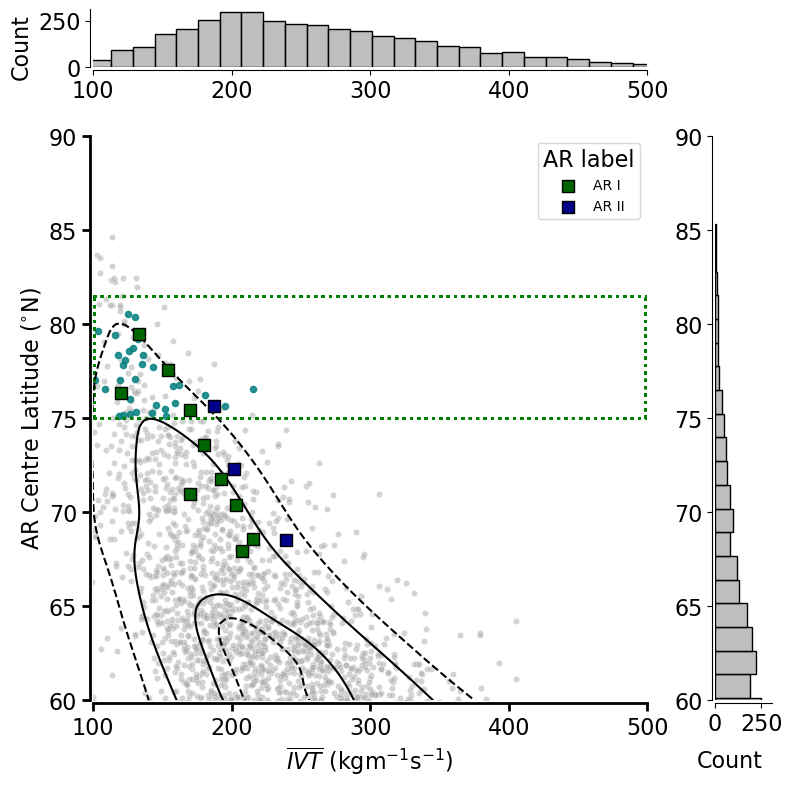

In [11]:
import plot_ar_climatology_campaign_comparison as plot_ar_clim

plot_ar_clim.main(regional_ARs,campaign_ARs,
                    season="spring",western_lon=-60,
                      eastern_lon=40,analysed_var="ivt",
                 highlight_center_box=True)